Hans Hwang and Jenniber Franco

## CS341 Project 4: Genetic Algorithms

Your first goal is to analyze the performance of several genetic algorithms in the context of parameter-estimation. Your second goal is to analyze the results, i.e. what do we learn about the model? In this project, we are revisiting Goldbeter's 5-state fly clock model, whose parameters were originally chosen "by hand." You will use a cost function which ensures the oscillations in constant darkness have a period of 23.6 hours.

There are many, many variants of genetic algorithms. We will be using the following algorithm.

<ul>
    <li>Create an initial population of $\lambda$ individuals $G^0$ and generate their costs.
    <li>Sort the individuals by cost (in preparation for selection)
    <li>For each generation $g$
        <ul>
        <li>Take the $eliteCount$ best children from the previous generation $G^{g-1}$ and put them into this generation $G^g$
        <li>Select the breeding pool $P$ of $\mu$ individuals from the previous generation.
        <li>For i in range($eliteCount$,$\lambda$)
            <ul>
            <li>Randomly select two parents from $P$.
            <li>Use cross-over to generate a child $G^g_i$.
            <li>Mutate the values in $G^g_i$.
            <li>Compute the child's cost.
            </ul>
        <li>Sort the individuals in $G^g_i$ by cost (in preparation for selection)
        </ul>
</ul>   

The key operators and parameters can be varied:
<ul>
    <li>Selection can favor fit (low-cost) parents more or less. If we favor them more, then the algorithm converges quickly, but it doesn't explore parameter space very well, and could miss a more fit individual. If we favor them less, the algorithm might not find children of increasingly good fitness. Explanations of several selection operators may be found in: Blickle, T. and Thiele, L. 1995. A comparison of selection schemes used in genetic algorithms. Tech. Rep. TIK-Report 11, Swiss Federal Institute of Technology (ETH), Zurich, Switzerland, May.
    <li>Crossover is typically "uniform" (each element of the child is randomly taken from one of its two parents) or "single" (a cross-over point is selected and all elements up to the cross-over point are taken from one parent and the remaining elements are taken from the second parent).
    <li>Mutation is typically implemented by choosing a value from a Gaussian distribution centered on each element. One straightforward way to vary the mutation is to vary the width of the distribution. We control the size of the mutation by scaling the width of the Gaussian distribution (it should be $mutationScale\cdot parameterValue$).
    <li>The number of parents $\mu$ and children $\lambda$ affects how widely we can sample space. Large numbers of children allow for a broader sampling. The number of parents (the size of the breeding pool) should be a fraction of the number of children (typically, it is a number like 1/5). It works with the selection operator to control how broadly the space is searched and how quickly the algorithm progresses towards a solution. The number of children that you need to use depends upon the problem. It can range from in the tens (e.g. our simple island cost function from class) to thousands.
    <li>The number of elite individuals should be small (e.g. 1 to 3). Including elites guarantees that the best-fit individual in generation $g$ will be at least as fit as the best-fit individual in generation $g-1$.
    <li>The number of generations should be as big as it needs to be for the best (or average) cost to stop improving. For some problems, thousands of generations are used. Here, we are able to use many fewer (e.g. I used 5 for the simple island cost function in class)
</ul>  

## Algorithm Performance

<ol>
<li> Run each algorithm on the fly model at least 5 times for each ``flavor'' for at least 5 generations,  i.e. analyze performance for 
	<ol>
    <li> a GA with truncation selection, an elite count of 1, 10 parents, 50 children, and a mutation scale of 0.05
	<li> a GA with tournament selection (tournament size = 2), an elite count of 1, 10 parents, 50 children, and a mutation scale of 0.05
	<li> a GA with linear ranking selection, an elite count of 1, 8 parents, 40 children, and a mutation fraction of 0.05
    </ol>
<li> Report your results in a concise, but informative manner. You will want to identify trends. To do this, quantify the performance of the algorithm. For example, determine the mean population cost from generation to generation.
</ol>

## Implication for Model
Using some of your output from above, analyze the effects of different parameters on the model's performance. Below are suggestions to guide your analysis. Follow at least one of them.

<ol>
<li> How different are the parameter sets? Do wildly different parameter sets map to wildly different outputs? Are their patterns?
<li> You may see different relationships between amplitudes of clock components. Do you see any patterns in this behavior? If not, maybe you can conclude that the relative amplitude is not a property of the model's parameters, but that it is a property of its structure. Make a detailed case for your conclusion.
<li> Choose several parameter sets and determine whether or not the non-intuitive behavior mentioned in Goldbeter's paper occurs. In his paper, he showed that increasing the rate of Per protein degradation ($v_d$) increases the total PER in the system. Is this true for multiple parameter sets?
</ol>

## Extensions

<ul>
<li> Implement proportional selection and include analysis of the GA with proportional selection it in your write-up.
<li> Include additional analysis with different values of the algorithm's parameters. What happens if the number of children per generation is different? What about increasing or decreasing the mutation fraction?
<li> Include simulated annealing in your set of optimization algorithms.
<li> Implement a simulated annealing optimization algorithm.
<li> Make a hybrid algorithm that uses both a GA (or simulated annealing) and a deterministic method (e.g. a hill-descending method). The idea is that the stochastic algorithms helps you find the right region of parameter space, and that in that region, the cost function will be smooth (and maybe even monotonic). Once we are in a region that is smooth and monotonic, we can use a deterministic optimization method to refine our parameter set to find the local optimum.
<li> Include amplitude in the cost function for Goldbeter's model: add a penalty for each state variable whose peak-to-trough amplitude is less than 0.1.
<li> Also find parameters for the Gonze/Goodwin oscillator.
</ul>


## Steps to get you started
### 1. Cost function for fly clock model

To write the cost function for the fly clock model, you will need gol95_model and get_period from project 2. 

Your cost function should have the signature:
<code>
def gol95_cost( params ):    
</code>

where params is the ndarray of parameters used to simulate the model.

It should
<ul>
    <li>Run the simulation with params as the parameters for at least 10 days, so that it is likely to have reached the limit cycle.
    <li>Re-run the simulation, beginning with the values from the final time step of the previous simulation.
    <li>Compute the period $per$ and the cycle-to-cycle standard deviation of the period $sdper$ by calling get_period.
    <li>Compute the cost according to
        $\sqrt{ \frac{per-23.6}{23.6}^2 + sdper/23.6}$
</ul>


In [4]:
## Write your code here (copy-paste the model and get_period, write gol95_cost)
import numpy as np
import scipy.integrate
import scipy.signal

def negative_feedback(t, statevars, params):
    M = statevars[0]
    P0 = statevars[1]
    P1 = statevars[2]
    P2 = statevars[3]
    PN = statevars[4]
    PT = statevars[5]

    vs = params[0]
    vm = params[1]
    Km = params[2]
    ks = params[3]
    vd = params[4]
    k1 = params[5]
    k2 = params[6]
    KI = params[7]
    Kd = params[8]
    n = params[9]
    K1 = params[10]
    K2 = params[11]
    K3 = params[12]
    K4 = params[13]
    V1 = params[14]
    V2 = params[15]
    V3 = params[16]
    V4 = params[17]

    dydt = np.zeros( (6,) )
    dydt[0] = ( vs * ((KI**n)/(KI**n + PN**n)) ) - ( vm * ((M)/(Km + M)) )
    dydt[1] = ks*M - (V1 * ((P0)/(K1+P0))) + (V2 * ((P1)/(K2+P1)))
    dydt[2] = (V1*((P0)/(K1+P0))) - (V2*((P1)/(K2+P1))) - (V3*((P1)/(K3+P1))) + (V4*((P2)/(K4+P2)))
    dydt[3] = (V3*((P1)/(K3+P1))) - (V4*((P2)/(K4+P2))) - (k1*P2) + (k2*PN) - (vd*((P2)/(Kd+P2)))
    dydt[4] = (k1*P2) - (k2*PN)
    dydt[5] = dydt[1]+dydt[2]+dydt[3]+dydt[4]
    return dydt

def get_period(arr,t):
    peaks, _ = scipy.signal.find_peaks(arr)
    #print(peaks)
    time = []
    for peak in peaks:
        time.append(t[peak])
    periods = []
    #print(time)
    for i in range(len(time)-1,0,-1):
        periods.append(time[i] - time[i-1])
        
    return (np.mean(periods), np.std(periods))
    #return np.mean(periods)

def gol95_cost(params):
    initial = (0.5, 0.5, 0.5, 0.5, 1, 2)
    initial = (1,1,1,1,1,1)
    nf = lambda t,y : negative_feedback(t, y, params)
    sol1 = scipy.integrate.solve_ivp(fun=nf, t_span=(0,240), y0=initial, t_eval=np.arange(0,240,0.01))
    sol2 = scipy.integrate.solve_ivp(fun=nf, t_span=(0,240), y0=sol1.y[:,-1], t_eval=np.arange(0,240,0.01), rtol=1e-8)
    (per, sdper) = get_period(sol2.y[0,:], sol2.t)
    #print(per, sdper)
    #per = get_period(sol2.y[1,:], sol2.t)
    #sdper = np.std(per)
    return np.sqrt( ((per-23.6)/23.6)**2 + sdper/23.6 )

vs = 0.76
vm = 0.65
Km = 0.5
ks = 0.38
vd = 0.95
k1 = 1.9
k2 = 1.3
KI = 1
Kd = 0.2
n = 4
K1 = 2
K2 = 2
K3 = 2
K4 = 2
V1 = 3.2
V2 = 1.58
V3 = 5
V4 = 2.5
params = (vs, vm , Km, ks, vd, k1, k2, KI, Kd, n, K1, K2, K3, K4, V1, V2, V3, V4)

print(gol95_cost(params))

# Test your cost function here.
# When Stephanie tests hers with the parameters from Project 2, her cost is
# 0.0027454617448506194

0.013531896019340541


### 2. Selection operator

Write your selection operators in this cell, so that you can test them with artificial data. I have included a barebones operator along with test code below. The uniform operator is a useless one, because it applies no selection pressure. The test code has costs ranging from 0.1 to 500 and the uniform operator samples from them all, so the histogram of costs from the breeding pool should indicate a uniform distribution from 0.1 to 500. 

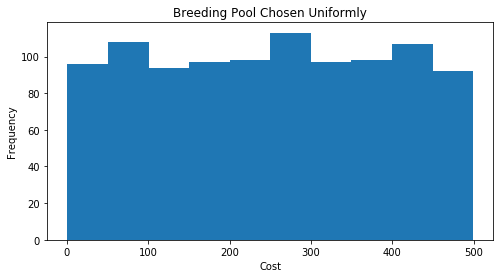

In [5]:
import matplotlib.pyplot as plt
import numpy as np

class GASettings:
    def __init__( self, numParents = 10, numChildren = 50 ):
        self.numParents = numParents;
        self.numChildren = numChildren;
        self.numGenerations = 5;
        self.selection = 'truncation'; 
        self.slope = 15; # for linear ranking selection
        self.tournamentSize = 2;
        self.crossover = 'uniform';
        self.mutation = 0.05; # std of normal distribution computed as mutation*value
        self.eliteCount = 1;
        self.linearRankingRatio = 4;

def select_pool( G, Gcost, settings ):
    if Gcost.size != settings.numChildren:
        print("problem")
        return
    P = np.zeros( (settings.numParents,G.shape[1]) )
    Pcost = np.zeros( (settings.numParents,) )
    Pidxs = []
    if settings.selection == 'truncation':
        for i in range(settings.numParents):
            idx = np.random.choice(settings.numParents)
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == 'uniform':
        for i in range(settings.numParents):
            idx = np.random.choice(G.shape[0])
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == "tournament":
        for i in range(settings.numParents):
            idx = (np.random.choice(G.shape[0], (settings.tournamentSize,))).min() #we are looking through indexes here
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == "linearRanking":
        r = settings.linearRankingRatio
        n = settings.numChildren
        pn = 2/n*(1/(1+r))
        p1 = r*pn
        ps = np.zeros((n,))
        for i in range(1,n+1):
            ps[i-1] = pn + (p1-pn)*(n-i)/(n-1)
        cs = ps.cumsum()

        for i in range( settings.numParents ):
            num = np.random.random() # number between 0 and 1, from uniform distribution
            idx = np.argmax( num < cs )
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    else:
        print("Unknown selection operator: ", settings.selection)
    return (P, Pcost)

# Test the selection operators
# Make fake parameters, using the index as the values (so we can differentiate them)
lam = 10000 # number of individuals in generation
mu = 1000 # number of individuals in breeding pool
NP = 5 # num of parameters per individual
G = np.zeros( (lam,NP) )
for i in range(lam):
    G[i,:] = i
Gcost = np.linspace(0.1,500,lam)
settings = GASettings(numParents=mu, numChildren=lam)

settings.selection = 'uniform'
(P, Pcost) = select_pool(G, Gcost, settings)
plt.figure( figsize=(8,4) )
plt.hist( Pcost );
plt.title( "Breeding Pool Chosen Uniformly")
plt.xlabel( 'Cost')
plt.ylabel('Frequency');



### 3. Test cross-over and mutation

Stephanie puts cross-over and mutation in a function named generateChild. The input to generateChild is the cost function, the breeding pool, the lower bounds, the upper bounds, and the settings. You can test it by generating an artificial breednig pool, such as one in which the first individual is an array of all 1's, the second is all 2's etc. Then, if you print out the results, which two individuals were chosen, how the cross-over was done and how the mutation worked should be clear.

In [6]:
# Write your code for testing cross-over and mutation here.
def generateChild(cost_fcn, P, lb, ub, settings):
    params = np.zeros(lb.shape)
    cost   = np.inf
    for i in range(1000):
        P1idx = np.random.choice(P.shape[0])#pick a parent
        P1  = P[P1idx,:]#chooses that parent
        P2idx = np.random.choice(P.shape[0])#picks another
        P2  = P[P2idx,:]#chooses and locks second
        for j in range(lb.size):
            if np.random.random() < 0.5:
                params[j] = P1[j]
            else:
                params[j] = P2[j]
        #50% to get one trait from one, and 50 for other
        # Mutate optimization variables
        params = np.multiply( 1+np.random.randn(params.size)*settings.mutation, params)#mutation
        # Make sure the mutation hasn't moved us out of bounds
        params = np.maximum(params,lb)#bigger of what it is and the lower bound
        params = np.minimum(params,ub)#smaller of what it is and upper bound
        cost   = cost_fcn(params) # same cost function area as before

        if np.isfinite(cost):
            return ( params, cost )
    return (np.zeros((lb.size)), np.inf)

lam = 50 # number of individuals in generation
mu = 2 # number of individuals in breeding pool
NP = 18 # num of parameters per individual 
P = np.zeros( (mu,NP) )
for i in range(mu):
    P[i,:] = i % 5 + 1
settings = GASettings(numParents=mu, numChildren=lam)

lb = np.zeros((18,))
ub = 5 + np.zeros((18,))
(params,cost) = generateChild( gol95_cost, P, lb, ub, settings )

print( "Breeding Pool")
print( P )
print( "Child")
print(params)

Breeding Pool
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]
Child
[2.04141241 1.83301884 2.1015306  2.01569256 1.98281066 1.9069746
 1.89542724 2.05509138 2.09060735 1.89093372 1.98882226 2.02533366
 1.9352166  1.97231352 1.9884413  2.07061778 2.15563847 2.0440344 ]


### 4. Write your Genetic Algorithm

Write it according to the algorithm above and what we have done in class.

Test it with the simple island cost function from class.

Best of generation  1  has cost  1.5033364673197736
Best of generation  2  has cost  1.5001521917381695
Best of generation  3  has cost  0.9748029899287897
Best of generation  4  has cost  0.8540268321965037
Best of generation  5  has cost  0.6735911213015289


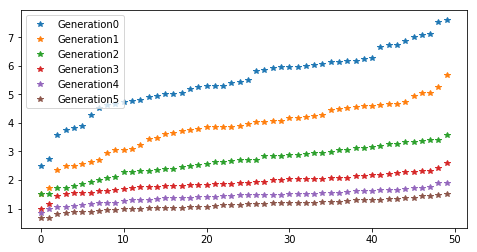

In [7]:
# Your GA code goes here! Copy-paste the simple island cost function from the Jupyter notebook from class.
def generateIndividual(cost_fcn, lb,ub):
    params = np.zeros(lb.shape);
    cost   = np.inf;
    for i in range( 1000 ):
        params = lb + np.multiply( np.random.random(lb.size), ub-lb);
        cost   = cost_fcn(params);
        if np.isfinite(cost):
            return (params, cost);
    return (params, np.inf)

def GA(cost_fcn, lb, ub, settings):
    mu = settings.numParents;
    lam = settings.numChildren;
    numGenerations = settings.numGenerations;

    # Create initial population
    G = np.zeros( (lam,lb.size) );
    Gcost = np.zeros( (lam,) );
    for i in range(lam):
        (G[i,:], Gcost[i]) = generateIndividual(cost_fcn, lb, ub);
    # sort them by cost
    idx   = np.argsort(Gcost);
    Gcost = Gcost[idx]
    G     = G[idx,:];
    all_params = [G]
    all_costs = [Gcost]

    for g in range(numGenerations):
        # Promote any elites
        elites = G[:settings.eliteCount,:]
        eliteCosts = Gcost[:settings.eliteCount]
        # select breeding pool
        (P, Pcost) = select_pool( G, Gcost, settings )
        # Generate the children for generation g
        G = np.zeros((lam, lb.size));
        Gcost = np.zeros((lam,));
        G[:settings.eliteCount,:] = elites
        Gcost[:settings.eliteCount] = eliteCosts
        for i in range(settings.eliteCount,lam):
           (G[i,:], Gcost[i]) = generateChild(cost_fcn, P, lb, ub, settings); 
        # sort the children of this generation
        idx   = np.argsort(Gcost);
        Gcost = Gcost[idx]
        G     = G[idx,:];
        print('Best of generation ', g+1, ' has cost ', Gcost[0]);
        all_params.append(G)
        all_costs.append(Gcost)

    params = G[0,:];
    cost   = Gcost[0];
    return (params, cost, all_params, all_costs)


def pattern_cost_function( params ):
    return scipy.linalg.norm( params-np.array([1,5,2.5,2,4,3,0]) )

PN = 7
lb = np.zeros( (PN,) );
ub = 5 + np.zeros( (PN,) );
cost_fcn = pattern_cost_function;
settings = GASettings(numParents=10, numChildren=50)
settings.numGenerations = 5;
settings.eliteCount = 1;
settings.selection = 'truncation';

(params, cost, all_params, all_costs) = GA(pattern_cost_function, lb, ub, settings);

plt.figure( figsize=(8,4) )
legs = []
for i in range(len(all_costs)):
    plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
    legs.append( "Generation" + str(i) )
plt.legend( legs );

### 5. Run you Genetic Algorithm on the Fly Clock Model

Below, I supply code that generates the upper and lower bounds for the parameters. The rest is up to you.

Best of generation  1  has cost  0.10458961045184999
Best of generation  2  has cost  0.10458961045184999
Best of generation  3  has cost  0.10458961045184999
Best of generation  4  has cost  0.10458961045184999
Best of generation  5  has cost  0.10458961045184999


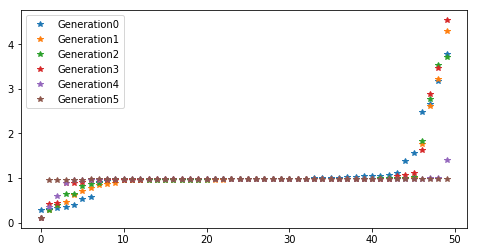

In [10]:
# Code with lower and upper bounds the parameters in Goldbeter's fly clock model.
# I put the published values in comments.

lb = np.zeros((18,));
ub = np.zeros((18,));
lb[0] = 0;   ub[0] = 1;# vs = 0.76;
lb[1] = 0;   ub[1] = 1;# vm = 0.65;
lb[2] = .1;  ub[2] = 1;# Km = 0.5;
lb[3] = 0;   ub[3] = 1;# ks = 0.38;
lb[4] = 0;   ub[4] = 1;# vd = 0.95;
lb[5] = 0;   ub[5] = 2;# k1 = 1.9;
lb[6] = 0;   ub[6] = 2;# k2 = 1.3;
lb[7] = 1;   ub[7] = 1;# KI = 1;
lb[8] = 0.1; ub[8] = 1;# Kd = 0.2;
lb[9] = 4;  ub[9] = 4;# n = 4;
lb[10] = 0.5;  ub[10] = 2.5;# K1 = 2;
lb[11] = 0.5;  ub[11] = 2.5;# K2 = 2;
lb[12] = 0.5;  ub[12] = 2.5;# K3 = 2;
lb[13] = 0.5;  ub[13] = 2.5;# K4 = 2;
lb[14] = 0;  ub[14] = 5;# V1 = 3.2;
lb[15] = 0;  ub[15] = 5;# V2 = 1.58;
lb[16] = 0;  ub[16] = 5;# V3 = 5;
lb[17] = 0;  ub[17] = 5;# V4 = 2.5;


settings = GASettings(numParents=10, numChildren=50)
settings.numGenerations = 5
settings.eliteCount = 1
settings.selection = 'uniform'

(params, cost, all_params, all_costs) = GA(gol95_cost, lb, ub, settings)

plt.figure( figsize=(8,4) )
legs = []
for i in range(len(all_costs)):
    plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
    legs.append( "Generation" + str(i) )
plt.legend( legs );

   ## Begin your project here
   
  Complete the project (analyzing the algorithm's performance and the parameters output) here. You can add your new selection operators to the code in cells above. Just concentrate main code for the report here.


Best of generation  1  has cost  0.0409901531319663
Best of generation  2  has cost  0.02362876701077401
Best of generation  3  has cost  0.02362876701077401
Best of generation  4  has cost  0.016822146560224863
Best of generation  5  has cost  0.013998605148245233
Best of generation  1  has cost  0.019771589402484045
Best of generation  2  has cost  0.019771589402484045
Best of generation  3  has cost  0.019771589402484045
Best of generation  4  has cost  0.019771589402484045
Best of generation  5  has cost  0.019771589402484045
Best of generation  1  has cost  0.03401769230606975
Best of generation  2  has cost  0.020194381178129946
Best of generation  3  has cost  0.020194381178129946
Best of generation  4  has cost  0.019391288164341523
Best of generation  5  has cost  0.019391288164341523
Mean Population Cost:  [0.55138597 0.97957592 1.00347792]


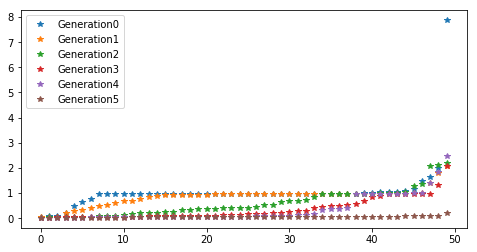

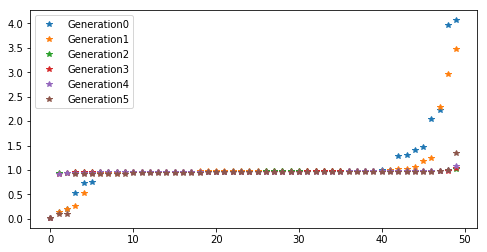

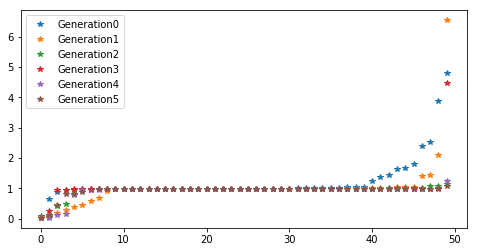

In [11]:
# Start code here and write-up here. :)
# Algorithm Performance
# Run each algorithm on the fly model at least 5 times for each ``flavor'' for at least 5 generations, i.e. analyze performance for
# a GA with truncation selection, an elite count of 1, 10 parents, 50 children, and a mutation scale of 0.05
# a GA with tournament selection (tournament size = 2), an elite count of 1, 10 parents, 50 children, and a mutation scale of 0.05
# a GA with linear ranking selection, an elite count of 1, 8 parents, 40 children, and a mutation fraction of 0.05
# Report your results in a concise, but informative manner. You will want to identify trends. To do this, quantify the performance of the algorithm. For example, determine the mean population cost from generation to generation.
lb = np.zeros((18,));
ub = np.zeros((18,));
lb[0] = 0;   ub[0] = 1;# vs = 0.76;
lb[1] = 0;   ub[1] = 1;# vm = 0.65;
lb[2] = .1;  ub[2] = 1;# Km = 0.5;
lb[3] = 0;   ub[3] = 1;# ks = 0.38;
lb[4] = 0;   ub[4] = 1;# vd = 0.95;
lb[5] = 0;   ub[5] = 2;# k1 = 1.9;
lb[6] = 0;   ub[6] = 2;# k2 = 1.3;
lb[7] = 1;   ub[7] = 1;# KI = 1;
lb[8] = 0.1; ub[8] = 1;# Kd = 0.2;
lb[9] = 4;  ub[9] = 4;# n = 4;
lb[10] = 0.5;  ub[10] = 2.5;# K1 = 2;
lb[11] = 0.5;  ub[11] = 2.5;# K2 = 2;
lb[12] = 0.5;  ub[12] = 2.5;# K3 = 2;
lb[13] = 0.5;  ub[13] = 2.5;# K4 = 2;
lb[14] = 0;  ub[14] = 5;# V1 = 3.2;
lb[15] = 0;  ub[15] = 5;# V2 = 1.58;
lb[16] = 0;  ub[16] = 5;# V3 = 5;
lb[17] = 0;  ub[17] = 5;# V4 = 2.5;
#save each mean population cost and compare at end
meanPopulationCost = np.zeros((3,))

#Truncation Selection, elite count = 1, 10 parents, 50 children, mutation 0.05
settings = GASettings(numParents=10, numChildren=50)
settings.numGenerations = 5 #for all
settings.eliteCount = 1
settings.selection = 'truncation'
settings.mutation = 0.05

(params, cost, all_params, all_costs) = GA(gol95_cost, lb, ub, settings)
# print("Cost: ", cost)
# print("All Costs: ", all_costs)
meanPopulationCost[0] = np.mean(all_costs)
plt.figure( figsize=(8,4) )
legs = []
for i in range(len(all_costs)):
    plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
    legs.append( "Generation" + str(i) )
plt.legend( legs );

#Tournament Selection: elite count = 1, 10 parents, 50 children, mutation 0.05, tournamentSize 2
settings = GASettings(numParents=10, numChildren=50)
settings.numGenerations = 5 #for all
settings.eliteCount = 1
settings.selection = 'tournament'
settings.mutation = 0.05
settings.tournamentSize = 2

(params, cost, all_params, all_costs) = GA(gol95_cost, lb, ub, settings)
meanPopulationCost[1] = np.mean(all_costs)
plt.figure( figsize=(8,4) )
legs = []
for i in range(len(all_costs)):
    plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
    legs.append( "Generation" + str(i) )
plt.legend( legs );

#Linear Ranking Selection: elite count = 1, 8 parents, 40 children, mutation 0.05, 
(params, cost, all_params, all_costs) = GA(gol95_cost, lb, ub, settings)
meanPopulationCost[2] = np.mean(all_costs)
plt.figure( figsize=(8,4) )
legs = []
for i in range(len(all_costs)):
    plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
    legs.append( "Generation" + str(i) )
plt.legend( legs );

print("Mean Population Cost: ", meanPopulationCost)

<hr style="border:2px solid gray"> </hr>

Acknowledgements

*Replace this text with links to external resources and thanks to people you worked with.*